In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.sandbox.google.com/github/https-deeplearning-ai/sc-gc-c4-gemini-public/blob/main/lesson-2/L2_colab_prompting_and_parameters.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Cost Estimate

The estimated cost for running this notebook once using your Google Cloud account, without the video segment (which has been converted to markdown), should be less than 0.10 USD (as of August 2024). Get the latest Gemini costs [here](https://cloud.google.com/vertex-ai/generative-ai/pricing).


# SETUP

This is follow up to the [How to Set Up your Google Cloud Account](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/9/how-to-set-up-your-google-cloud-account-|-try-it-out-yourself-[optional]) instructions from the course, [Large Multimodal Model Prompting with Gemini](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/1/introduction) on the [Learning Platform](https://learn.deeplearning.ai) of [DeepLearning.AI](https://www.deeplearning.ai).

### Install Vertex AI SDK and other Required Packages

In [1]:
%pip install --upgrade --user --quiet google-cloud-aiplatform

### Restart Runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your Notebook Environment (Colab Only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

**NOTE:** The Gmail email address you use to authenticate this lesson colab must be the same as the one you used to set up your Google Cloud account and your Project.

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud Project Information and Initialize Vertex AI SDK

**Add _your_ Project ID below**, which you created while following the [How to Set Up your Google Cloud Account](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/9/how-to-set-up-your-google-cloud-account-|-try-it-out-yourself-[optional]) instructions. If your `Project ID` was `dlai-shortcourse-on-gemini`, then you can run the cell below as it is. Otherwise, be sure to change it.

You can also look up your Project ID in your [Project Dashboard](https://console.cloud.google.com/projectselector2/home/dashboard).

In [2]:
PROJECT_ID = "dlai-shortcourse-on-gemini"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Utils Functions and Images

**Important Note:**

If using Google Colab, all the
```Python
from utils import ...
```

functions and all required images are readily accessible in the notebook. Execute the following cells to proceed.


In [3]:
import typing
import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

from vertexai.generative_models import (
    GenerationConfig,
    Image,
)

def gemini(prompt, model):
    responses = model.generate_content(prompt,
                                     stream=True)

    response_text = ""
    for response in responses:
        response_text += response.text

    return response_text

def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)

def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

def gemini_vision(contents_image, model):

    responses = model.generate_content(
        contents_image,
        stream=True)

    response_text = ""
    for response in responses:
        response_text += response.text
    return response_text

def gemini_vision_parameters(contents_image, model, config):

    responses = model.generate_content(
        contents=contents_image,
        generation_config=config,
        stream=True
    )

    response_text = ""
    for response in responses:
        response_text += response.text

    return response_text

In [4]:
# download images from bucket
! gsutil cp "gs://dlai-sc-gemini-bucket/Andrew_power_tools.png" ./andrew_power_tools.png
! gsutil cp "gs://dlai-sc-gemini-bucket/panda.png" ./panda.png

Copying gs://dlai-sc-gemini-bucket/Andrew_power_tools.png...
/ [1 files][710.5 KiB/710.5 KiB]                                                
Operation completed over 1 objects/710.5 KiB.                                    
Copying gs://dlai-sc-gemini-bucket/panda.png...
/ [1 files][974.9 KiB/974.9 KiB]                                                
Operation completed over 1 objects/974.9 KiB.                                    


# IN COURSE VIDEO

Lesson video starts from below.

# [Lesson 2: Multimodal Prompting and Parameter Control](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/3/multimodal-prompting-and-parameter-control)

In this notebook, you'll have a quick overview of simple text, image and video examples with Gemini, and learn about different Parameters which can be set up.

## Text Examples

Please note that Google's Gemini model `gemini-1.0-pro-002` [is being deprecated (soon)](https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations). Therefore, it is necessary to switch to the recommended replacement model, `gemini-2.0-flash`.

- Load the [gemini-2.0-flash](https://ai.google.dev/gemini-api/docs/models#gemini-2.0-flash) model.

In [5]:
from vertexai.generative_models import GenerativeModel

In [6]:
model = GenerativeModel("gemini-2.0-flash")

In [ ]:
# from utils import gemini

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

If you run the next cell and receive a `403 error`:


*   Recheck your project name, and be sure it matches the name assigned when setting up the Google Cloud Project. Note that project names are lowercase.
*   Ensure you completed Step 5 of the instructions on setting up Google Cloud and Vertex AI.

In [7]:
gemini("What is a multimodal model?", model=model)

'A multimodal model is a machine learning model that is trained on and processes information from **multiple modalities** or types of data.  Think of modalities as different senses or channels of information.\n\nHere\'s a breakdown:\n\n*   **Modality:** Refers to a distinct type of data. Common modalities include:\n    *   **Text:**  Written language, documents, code.\n    *   **Images:**  Photographs, drawings, scans.\n    *   **Audio:**  Speech, music, sounds.\n    *   **Video:**  A sequence of images with audio.\n    *   **Numerical/Tabular Data:** Spreadsheets, databases, sensor readings.\n    *   **3D Data:** Point clouds, meshes, volumetric data.\n    *   **Sensor Data:** Data from various sensors like accelerometers, gyroscopes, temperature sensors, etc.\n\n*   **Multimodal:**  "Multi" meaning many.  A multimodal system works with *at least* two modalities. It\'s about combining and integrating information from different sources to gain a more comprehensive understanding.\n\n*  

#### Under the hood of the helper functions

In [8]:
prompt_1 = """
In short, what is deeplearning.ai,
and what can it offer me as a Machine Learning Engineer?"
"""

- `stream=True` processes the response as it being generated.
- With `stream=False`, you have to wait until the entire response has been generated before it can be proccessed and printed.

In [9]:
response_1 = model.generate_content(prompt_1, stream=True)

In [10]:
response_1

<generator object _GenerativeModel._generate_content_streaming at 0x7ea0566f65c0>

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [11]:
for response in response_1:
    print(response)

candidates {
  content {
    role: "model"
    parts {
      text: "**"
    }
  }
}
usage_metadata {
}
model_version: "gemini-2.0-flash"
create_time {
  seconds: 1743750757
  nanos: 518241000
}
response_id: "ZYbvZ-HQH4qSmecP76-t6QI"

candidates {
  content {
    role: "model"
    parts {
      text: "In"
    }
  }
}
usage_metadata {
}
model_version: "gemini-2.0-flash"
create_time {
  seconds: 1743750757
  nanos: 518241000
}
response_id: "ZYbvZ-HQH4qSmecP76-t6QI"

candidates {
  content {
    role: "model"
    parts {
      text: " short, deeplearning.ai is an online education platform founded by Andrew Ng that"
    }
  }
}
usage_metadata {
}
model_version: "gemini-2.0-flash"
create_time {
  seconds: 1743750757
  nanos: 518241000
}
response_id: "ZYbvZ-HQH4qSmecP76-t6QI"

candidates {
  content {
    role: "model"
    parts {
      text: " offers courses, Specializations, and Professional Certificates in AI and deep learning.**\n\n**As a"
    }
  }
}
usage_metadata {
}
model_version: "ge

In [12]:
response_1 = model.generate_content(prompt_1,
                                     stream=True)

In [13]:
for response in response_1:
    print(response.text)

**
In short,
 deeplearning.ai is an educational company founded by Andrew Ng focused on making high-quality AI
 education accessible.**

**As a Machine Learning Engineer, deeplearning.ai can offer you
:**

*   **Skill Development:** Focused courses on deep learning, machine learning, and related topics like generative AI and MLOps, helping you to build and
 refine your core skills and stay up-to-date with the latest advancements.
*   **Career Advancement:**  Certifications and projects to add to your portfolio
, demonstrating your expertise and increasing your job prospects.
*   **Specialization:** Ability to specialize in specific areas like natural language processing, computer vision, or time series analysis to improve expertise in specific ML disciplines.
*   **Practical Knowledge
:** Emphasis on practical application with coding exercises and real-world examples to give you the tools you need to solve real-world problems.
*   **Community:** Access to a community of learners and ex

## Multimodality: Image + Text

In [14]:
from vertexai.generative_models import (
    GenerativeModel,
    Image,
    Part,
)

Please note that Google's Gemini model `gemini-1.0-pro-vision-001` [is being deprecated (soon)](https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations). Therefore, it is necessary to switch to the recommended replacement model, `gemini-2.0-flash`.

- Load the [gemini-2.0-flash](https://ai.google.dev/gemini-api/docs/models#gemini-2.0-flash) model.

In [15]:
multimodal_model = GenerativeModel("gemini-2.0-flash")

- Load a prompt and an image

In [16]:
image = Image.load_from_file("andrew_power_tools.png")

In [17]:
prompt_3 = "Please describe what is in this image?"

# prompt_3 = "What are likely professions of this person?"

In [18]:
contents_image = [image, prompt_3]

-------Prompt--------


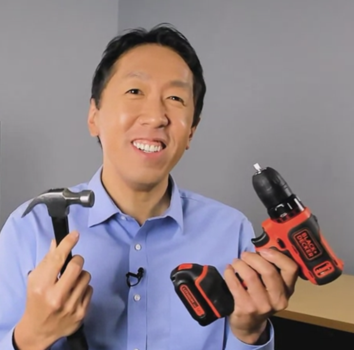

Please describe what is in this image?


In [19]:
# from utils import print_multimodal_prompt

print("-------Prompt--------")
print_multimodal_prompt(contents_image)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [20]:
# from utils import gemini_vision

gemini_vision(contents_image, model=multimodal_model)

'Here is a description of what is in the image:\n\nThe image shows an Asian man smiling at the camera. He is wearing a blue button-down shirt. He is holding a hammer in his left hand and a Black+Decker drill with its battery separate in his right hand. The background is a plain gray wall with a hint of a tan surface on the bottom right.\n'

## Multimodality: Video + Text

- Load a video and a prompt.
- The video loads from a GCP bucket.

In [21]:
file_path = "dlai-sc-gemini-bucket/pixel8.mp4"
video_uri = f"gs://{file_path}"
video_url = f"https://storage.googleapis.com/{file_path}"

In [22]:
import IPython

In [23]:
IPython.display.Video(video_url, width=450)

In [24]:
prompt = """
Answer the following questions using the video only:
 - What is the main person's profession?
 - What are the main features of the phone highlighted?
 - Which city was this recorded in?
"""

In [25]:
video = Part.from_uri(video_uri, mime_type="video/mp4")
contents_video = [prompt, video]

**Note:** This cell is converted to markdown to prevent accidentally executing it. The cost to run this cell is approximately 0.12 USD (as of August 2024).

```Python
responses_4 = multimodal_model.generate_content(contents_video, stream=True)
```

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [27]:
for response in responses_4:
    print(response.text, end="")

Okay, here are the answers to your questions based on the video only:

- What is the main person's profession?
   The main person is a photographer.

- What are the main features of the phone highlighted?
   The main features highlighted are "Video Boost" and "Night Sight," which improves image quality in low light.

- Which city was this recorded in?
    The video was recorded in Tokyo. Specifically Sancha and Shibuya.

## Gemini Model Parameters

Please note that Google's Gemini model `gemini-1.0-pro-vision-001` [is being deprecated (soon)](https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations). Therefore, it is necessary to switch to the recommended replacement model, `gemini-2.0-flash`.

- Load an image.
- You'll be using the [gemini-2.0-flash](https://ai.google.dev/gemini-api/docs/models#gemini-2.0-flash) model.
- First run the model using its _default parameters_.

In [28]:
image_1 = Image.load_from_file("./panda.png")

In [29]:
prompt_1 = """Write what is happening in the following image
from a unique perspective and do not mention names"""

In [30]:
contents = [image_1, prompt_1]

-------Prompt--------


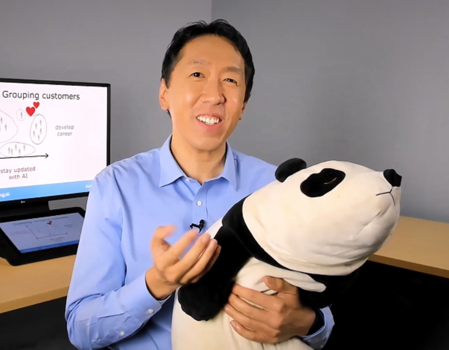

Write what is happening in the following image
from a unique perspective and do not mention names


In [31]:
# from utils import print_multimodal_prompt

print("-------Prompt--------")
print_multimodal_prompt(contents)

In [32]:
response_1 = multimodal_model.generate_content(
    contents,
    stream=True
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [33]:
for response in response_1:
    print(response.text, end="")

In a softly lit setting, a smiling individual in a light blue shirt cradles a plush panda. A screen behind them displays diagrams illustrating customer groupings, with phrases like "develop career" and "stay updated with AI" subtly visible. The scene suggests a blend of technology, learning, and a touch of warmth conveyed by the panda toy.

### Temperature, Top k

- GenerationConfig lets you set up the parameters for the model.

**Note:** In the latest version, `from vertexai.preview.generative_models` has been changed to `from vertexai.generative_models`.

`from vertexai.preview.generative_models` can still be used.

In [34]:
from vertexai.generative_models import GenerationConfig

In [ ]:
# from utils import gemini_vision_parameters

- Setting `temperature=0.0` and `top_k=1`

In [35]:
generation_config_1 = GenerationConfig(
    temperature=0.0,
    top_k=1,
)

In [36]:
response_zero_temp = gemini_vision_parameters(
                        contents,
                        multimodal_model,
                        generation_config_1)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [37]:
print(response_zero_temp)

In a brightly lit room, an individual with a warm smile is holding a plush panda. The person is wearing a light blue shirt and gesturing with their hands as if explaining something. Behind them, a monitor displays a presentation slide with the title "Grouping customers" and various diagrams. A tablet is also visible on a nearby surface, further suggesting a presentation or educational setting. The overall scene conveys a sense of friendliness and engagement, possibly in a learning or informational context.



In [38]:
responses_zero_temp = gemini_vision_parameters(
                        contents,
                        multimodal_model,
                        generation_config_1)

print(response_zero_temp)

In a brightly lit room, an individual with a warm smile is holding a plush panda. The person is wearing a light blue shirt and gesturing with their hands as if explaining something. Behind them, a monitor displays a presentation slide with the title "Grouping customers" and various diagrams. A tablet is also visible on a nearby surface, further suggesting a presentation or educational setting. The overall scene conveys a sense of friendliness and engagement, possibly in a learning or informational context.



- Setting `temperature=1` and `top_k=40`

In [39]:
generation_config_2 = GenerationConfig(
    temperature=1,
    top_k=40,
)

In [40]:
responses_high_temp_topk = gemini_vision_parameters(
                            contents,
                            multimodal_model,
                            generation_config_2)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [41]:
print(responses_high_temp_topk)

In a brightly lit studio, an individual with a warm smile is holding a plush panda bear. The person is wearing a light blue collared shirt, and the panda is cradled in their arms. Behind them, a monitor displays a diagram related to customer grouping, suggesting a presentation or educational setting. A tablet rests on a desk, further hinting at a technological or business context. The atmosphere is friendly and engaging, as though the speaker is trying to create a connection with their audience.


### Top p

- Setting `top_p=0.01`, and maintaining `temperature=1`, `top_k=40`

In [42]:
generation_config_4 = GenerationConfig(
    temperature=1,
    top_k=40,
    top_p=0.01,
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [43]:
responses_high_temp_topp = gemini_vision_parameters(
                            contents,
                            multimodal_model,
                            generation_config_4)

print(responses_high_temp_topp)

In a brightly lit room, an individual with a warm smile is holding a plush panda. The person is wearing a light blue shirt and gesturing with their hands as if explaining something. Behind them, a screen displays a presentation slide with the title "Grouping customers" and various diagrams. A tablet is also visible on a nearby surface, further suggesting a presentation or educational setting. The overall scene conveys a sense of friendliness and engagement, as if the person is making a complex topic more approachable with the help of a cuddly companion.



### Max Output Tokens

- The range for `max_output_tokens` is `1 (inclusive) to 2049 (exclusive)`
- When using `max_output_tokens`, the number of words returned by the model are 1 less than what you specify.
- So setting `max_output_tokens` to `1` will throw an error, since there would be no generated text.

In [44]:
generation_config_5 = GenerationConfig(
    max_output_tokens=10,
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [45]:
responses_max_output = gemini_vision_parameters(
                        contents,
                        multimodal_model,
                        generation_config_5)

print(responses_max_output)

In a well-lit setting, an individual is


### Stop Sequences

- The range for `stop_sequences` is `1 (inclusive) to 17 (exclusive)`
- Multiple (no more than 16) words, numbers, space or special characters can be passed as a `list`.
- The model response stops _just before_ the _first time_ it encounters any stop sequence.

In [46]:
generation_config_6 = GenerationConfig(
    stop_sequences=["panda"]
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [47]:
responses_stop = gemini_vision_parameters(
                    contents,
                    multimodal_model,
                    generation_config_6)

print(responses_stop)

In the frame, a person, dressed in a light blue shirt, beams while embracing a large, plush 
